# Final Project Database Design

In [19]:
import folium
import numpy as np
import pandas as pd
import geopandas as gp
import pyepsg
import os
#using gensim to create lda model and tfidf
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models
# combination spacy and nltk for lemmatization and stopwords
import spacy

from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

#using sklearn for dimesnion reduction LDA and TF-IDF----- 
#different LDA and TF-IDF needed for KMEANS clustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn import mixture


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import colorsys
#import colormap.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

#visualizes K-Means Clustering and Gaussian Mixture Model
from matplotlib.patches import Ellipse
import seaborn as sns
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

import re
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import math



In [20]:
#file path of the data
file = '/Users/tommy/documents/Database Design/Final_Proj/gun-violence-data_01-2013_03-2018.csv'


In [67]:
#importing data
state_outlines = gp.read_file('/Users/tommy/documents/Database Design/Final_Proj/gz_2010_us_outline_500k/gz_2010_us_outline_500k.shp')

pyepsg.get(state_outlines.crs['init'].split(':')[1])

shooting_data = pd.read_csv(file)

shooting_data = shooting_data[:100000]

incident_text = shooting_data['incident_characteristics'].map(str) + ' ' + shooting_data['notes'].map(str)
        
shooting_data.head()
        

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [68]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Cleaning Data and Constructing LDA model

In [42]:

data_lemmantized = []

def lda_model(text_data):
    
    
    # Remove new line characters
    text_data = [re.sub('\s+', ' ', sent) for sent in text_data]

    # Remove distracting single quotes
    text_data = [re.sub("\'", "", sent) for sent in text_data]

    text_data = [re.sub("\-", "", sent) for sent in text_data]

    data_words = list(sent_to_words(text_data))

    print(data_words[:1])
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    print(trigram_mod[bigram_mod[data_words[0]]])
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    print(data_lemmatized[:1])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print(corpus[:1])
    
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    
    return vis, lda_model, texts

        
        

vis, lda_model, data_lemmantized = lda_model(incident_text)

vis

[['shot', 'wounded', 'injured', 'mass', 'shooting', 'victims', 'injured', 'or', 'killed', 'excluding', 'the', 'subject', 'suspect', 'perpetrator', 'one', 'location', 'possession', 'gun', 'found', 'during', 'commission', 'of', 'other', 'crimes', 'possession', 'of', 'gun', 'by', 'felon', 'or', 'prohibited', 'person', 'julian', 'sims', 'under', 'investigation', 'four', 'shot', 'and', 'injured']]
['shot', 'wounded', 'injured', 'mass', 'shooting', 'victims', 'injured', 'or', 'killed', 'excluding', 'the', 'subject', 'suspect', 'perpetrator', 'one', 'location', 'possession', 'gun', 'found', 'during', 'commission', 'of', 'other', 'crimes', 'possession', 'of', 'gun', 'by', 'felon', 'or', 'prohibited_person', 'julian', 'sims', 'under_investigation', 'four', 'shot', 'and', 'injured']
[['shot', 'wound', 'injure', 'mass', 'shooting', 'victim', 'injure', 'kill', 'exclude', 'suspect', 'perpetrator', 'location', 'possession', 'gun', 'find', 'commission', 'crime', 'possession', 'gun', 'felon', 'prohibi

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.084533 -0.306980       1        1  37.001617
5     -0.072156 -0.308727       2        1  17.612679
8     -0.312171  0.170818       3        1  13.303788
9     -0.162797  0.135706       4        1   9.141954
1      0.066024 -0.136690       5        1   8.724313
6     -0.227371  0.127050       6        1   6.052351
0      0.181468  0.022703       7        1   5.283666
3      0.184548  0.077270       8        1   2.818984
4      0.213494  0.109425       9        1   0.030324
7      0.213494  0.109425      10        1   0.030324, topic_info=     Category         Freq                  Term        Total  loglift  \
16    Default  5230.000000                  shot  5230.000000  30.0000   
38    Default  5671.000000                   nan  5671.000000  29.0000   
20    Default  3287.000000                 wound  3287.000000  28.0000   
6     Default  3275.000000                injure  3275.000000  27.0000   
28    Default  4493.000000                 shoot  4493.000000  26.0000   
30    Default  2758.000000               suicide  2758.000000  25.0000   
21    Default  3193.000000            accidental  3193.000000  24.0000   
27    Default  2357.000000                murder  2357.000000  23.0000   
4     Default  5229.000000                  find  5229.000000  22.0000   
23    Default  2226.000000                  dead  2226.000000  21.0000   
113   Default  1512.000000                   man  1512.000000  20.0000   
37    Default  3860.000000                injury  3860.000000  19.0000   
44    Default  1701.000000               involve  1701.000000  18.0000   
5     Default  1888.000000                   gun  1888.000000  17.0000   
22    Default   971.000000                   car   971.000000  16.0000   
18    Default  1216.000000               suspect  1216.000000  15.0000   
59    Default  2899.000000                 death  2899.000000  14.0000   
61    Default  2876.000000              evidence  2876.000000  13.0000   
35    Default  1624.000000                  fire  1624.000000  12.0000   
36    Default  1470.000000              incident  1470.000000  11.0000   
65    Default  2631.000000               robbery  2631.000000  10.0000   
58    Default  2625.000000                 armed  2625.000000   9.0000   
60    Default  2466.000000                   dgu  2466.000000   8.0000   
626   Default   795.000000                action   795.000000   7.0000   
12    Default   861.000000           perpetrator   861.000000   6.0000   
13    Default   827.000000            possession   827.000000   5.0000   
1     Default   762.000000                 crime   762.000000   4.0000   
0     Default   725.000000            commission   725.000000   3.0000   
9     Default   888.000000                  kill   888.000000   2.0000   
46    Default  1667.000000               officer  1667.000000   1.0000   
...       ...          ...                   ...          ...      ...   
3966  Topic10     0.008236                  span     0.905770   3.4008   
1331  Topic10     0.008236                   cal     1.562997   2.8552   
1329  Topic10     0.008236                 casey     0.852208   3.4617   
1328  Topic10     0.008236           firebrother     0.852012   3.4620   
1327  Topic10     0.008236  elementary_secondary    62.442986  -0.8325   
1326  Topic10     0.008236              kangaroo     0.853915   3.4597   
1325  Topic10     0.008236                  safe     6.745987   1.3928   
1324  Topic10     0.008236                  zona     0.851999   3.4620   
1323  Topic10     0.008236              conspire     0.852013   3.4619   
1322  Topic10     0.008236             barricade     0.878835   3.4310   
1321  Topic10     0.008236                   own     0.852018   3.4619   
1320  Topic10     0.008236                 multi     0.852018   3.4619   
1319  Topic10     0.008236               weather     

# Wordcloud showing topic compostition

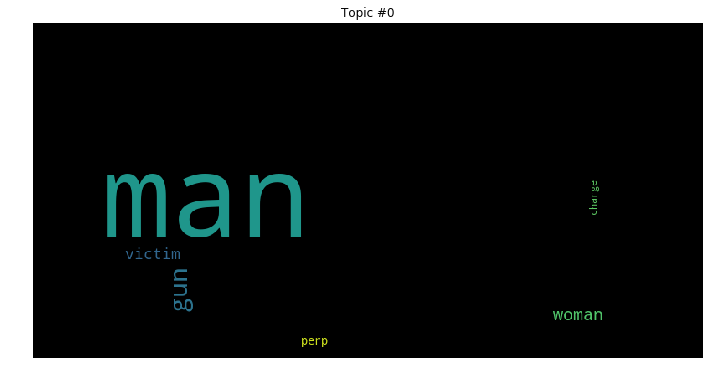

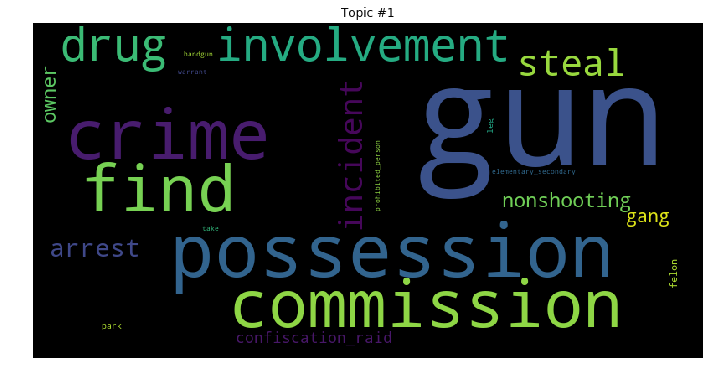

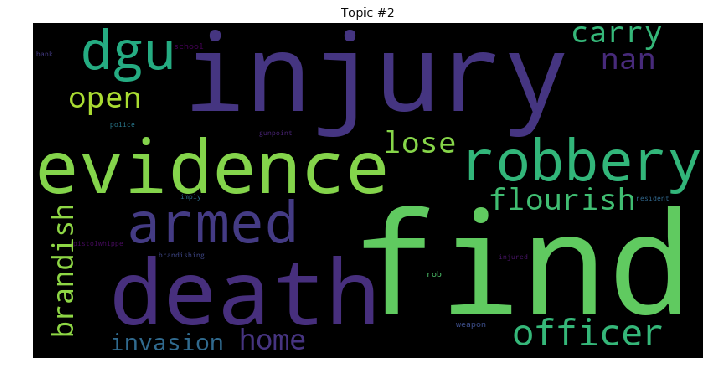

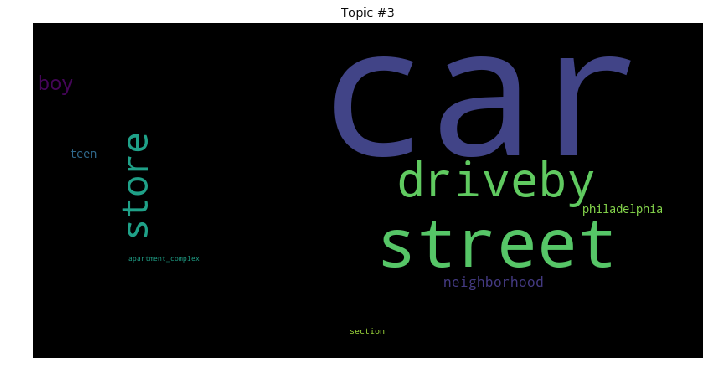

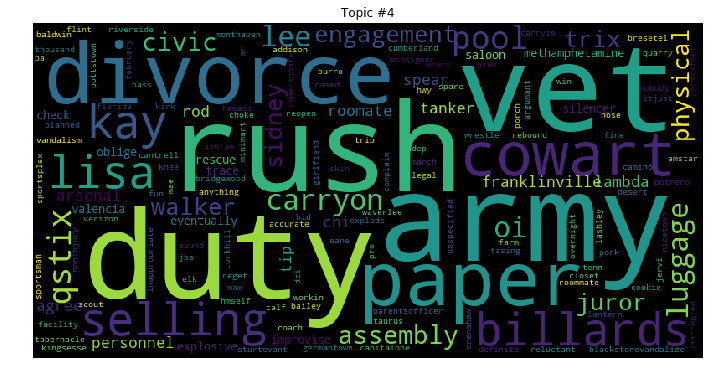

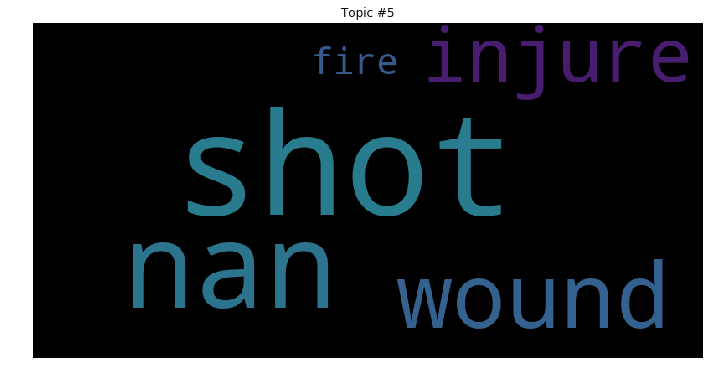

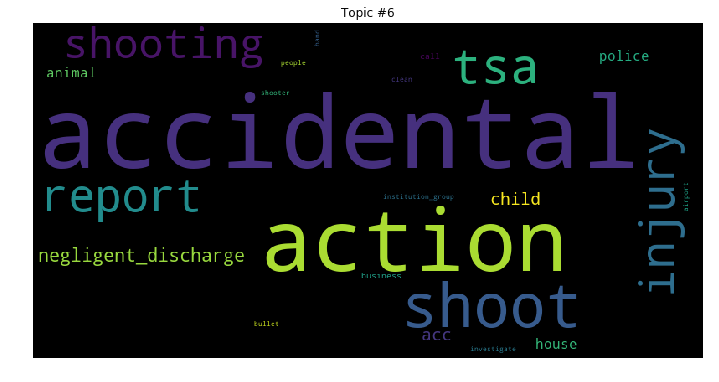

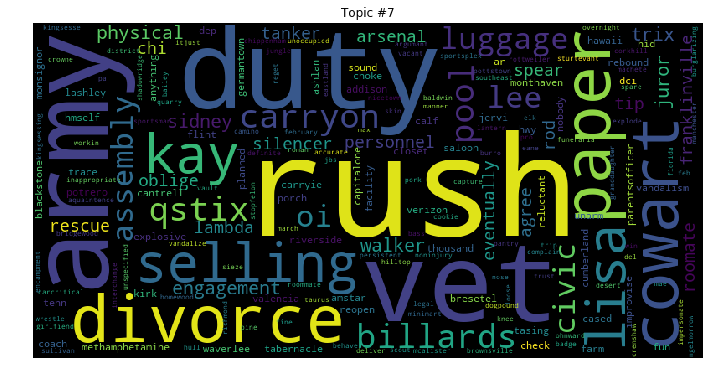

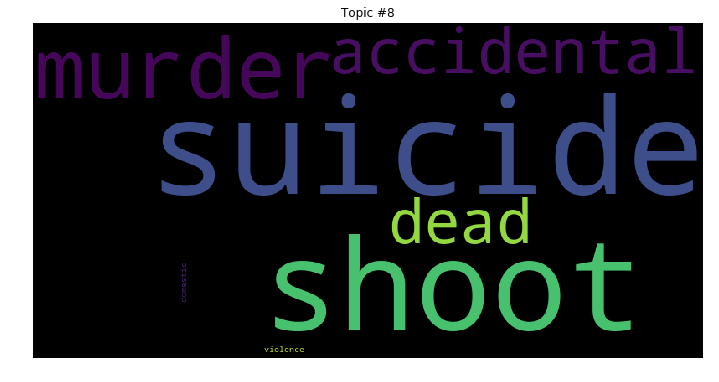

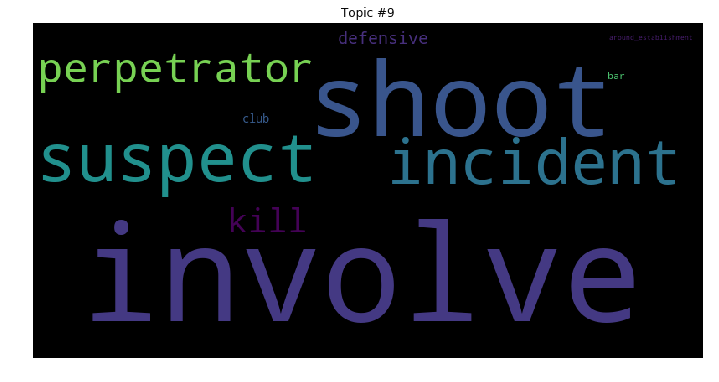

In [43]:
for idx in range(lda_model.num_topics):
    plt.figure(figsize=(12,12))
    plt.imshow(WordCloud(relative_scaling=1,scale=2).fit_words(dict(lda_model.show_topic(idx, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(idx))
    plt.show()

# TF-IDF and BOW implementation

In [44]:
def bag_of_words(data_lemmantized, d_df):
    """Return a term-document count matrix (matrix of # of occurences for each word where each column is a document)"""
    
    # get list of all words and list of word frequency vectors for each document
    all_words = []
    fdist_vectors = []
    for words in data_lemmantized:
        # get all words
        for word in words:

            all_words.append(word)
        
        # append frequency distribution of words for each document to fdist_vectors
        fdist_vectors.append(nltk.FreqDist(words))
    
    # get unique words and length of words
    all_words = list(set(all_words))
    len_vocab = len(all_words)
    
    
    # create vectors for each document with word frequency for each document for ALL words
    bag_vectors = []
    for vec in fdist_vectors:
        # initialize each bag of words vector to be zero vector with length of all_words
        bag_vector = np.zeros(len_vocab)
        for idx, word in enumerate(all_words):
            if word in vec:
                bag_vector[idx] = vec[word]
        bag_vectors.append(bag_vector)
    
    #files_names = [file_name[-5:] for file_name in files_sample]
    #df = pd.DataFrame(np.column_stack(bag_vectors), index=all_words, columns=files_names).astype(int)
    df = pd.DataFrame(np.column_stack(bag_vectors), index=all_words).astype(int)
    if(d_df):
        return bag_vectors, all_words, files_names
    else:
        return df

bow_matrix = bag_of_words(data_lemmantized, 0)


# convert bag of words matrix to binary term-document incidence matrix
tfidf_matrix = bow_matrix
tfidf_matrix[tfidf_matrix != 0] = 1

# get inverse document frequency
idf = np.log10(len(tfidf_matrix.columns)/tfidf_matrix.sum(axis=1))

# multiply bag of words matrix by frequency
tfidf_matrix = bow_matrix.multiply(idf,axis=0).round(2)

# use below if dictionary of dictionaries wanted with keys as file names ({column -> {index -> value}})
#tfidf.to_dict()
# use below if bag of words matrix wanted
tfidf_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
attack,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
task,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rebecca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lobs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
witness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-883483.03133102
-883149.9993310075
-878407.0258219357
-883452.6272050558


<Figure size 864x864 with 0 Axes>

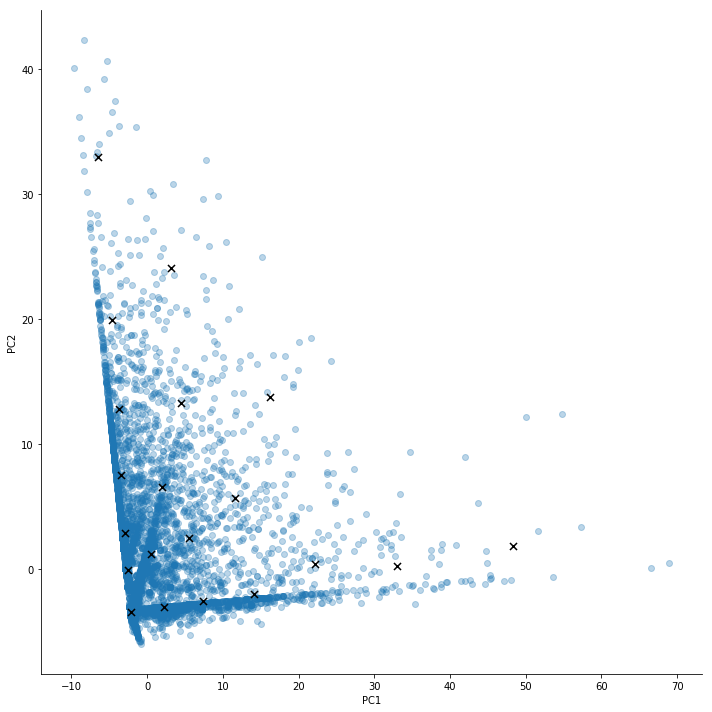

<Figure size 864x864 with 0 Axes>

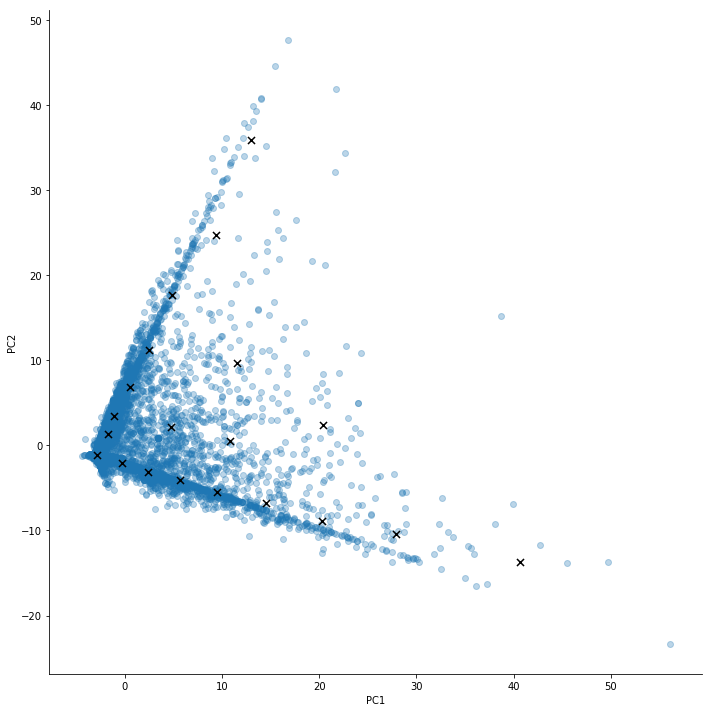

<Figure size 864x864 with 0 Axes>

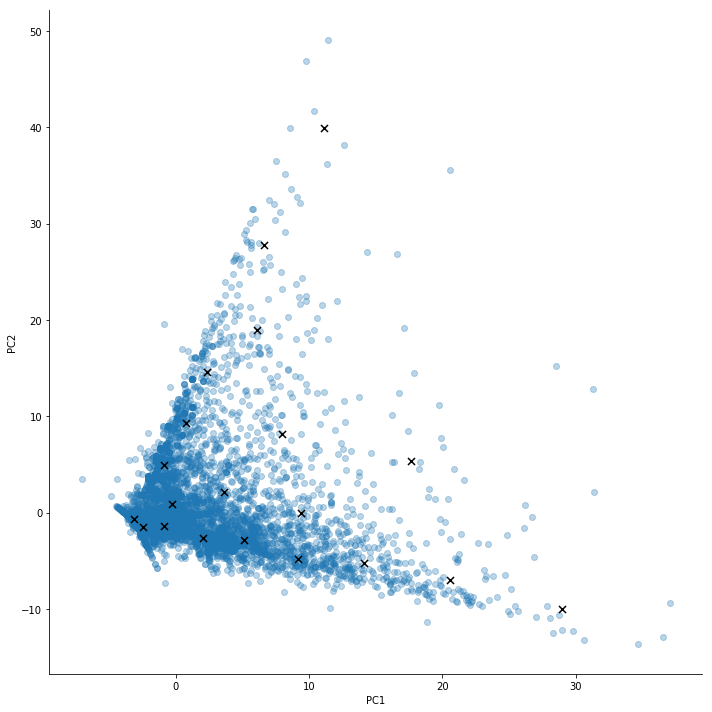

<Figure size 864x864 with 0 Axes>

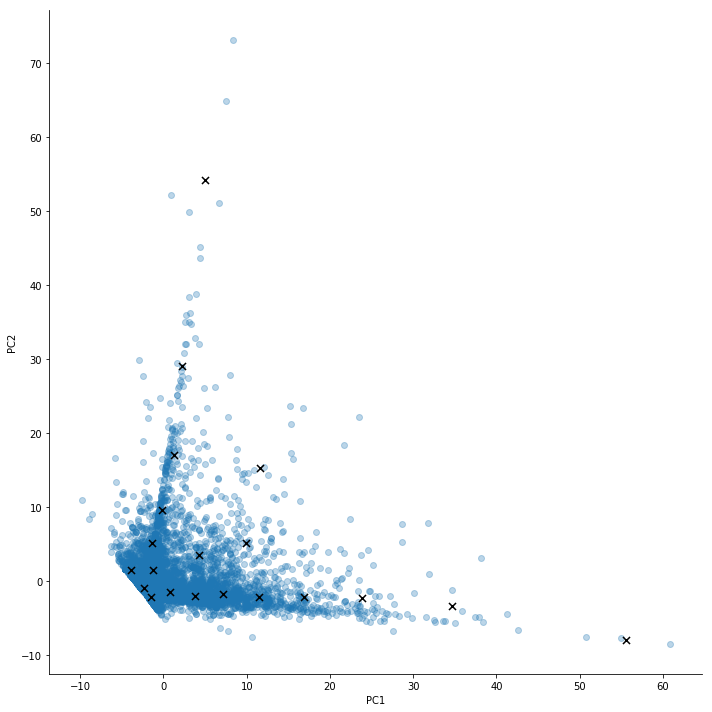

In [45]:

def kmeans_clustering(tfidf, n_topics, bow_matrix):
    
    lda_model = LDA(n_topics=n_topics,max_iter=20)

    lda_model.fit(tfidf)
    
    pca = PCA(n_components=2)
    
    two_vecs_LDA = pca.fit_transform(np.transpose(lda_model.components_))
    two_vecs_LDA_df = pd.DataFrame(two_vecs_LDA,columns=(['PC1', 'PC2']))

    print(lda_model.score(bow_matrix))
    
    plt.figure(figsize=(12,12))
    facet = sns.lmplot(data=two_vecs_LDA_df, x='PC1', y='PC2', 
                       fit_reg=False, 
                       legend=True, 
                       legend_out=True,
                       height=10,
                       scatter_kws={'alpha':0.3},
                       palette=None,
                       )
    ax = plt.gca()
    #ax.set_xlim([-25,200])
    #ax.set_ylim([-100,300])

    kmeans_lda = KMeans(n_clusters=20, random_state=0).fit(two_vecs_LDA)
    for x, y in kmeans_lda.cluster_centers_:
        plt.scatter(x, y, marker='x', s=50, c='k')

    
    return

kmeans_clustering(tfidf_matrix,6, bow_matrix)

kmeans_clustering(tfidf_matrix,7, bow_matrix)

kmeans_clustering(tfidf_matrix,8, bow_matrix)

kmeans_clustering(tfidf_matrix,9, bow_matrix)

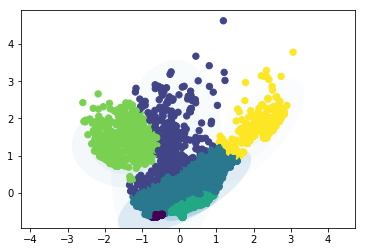

In [46]:


def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


def gaussian_mixture(tfidf, n_crimes):
    
    pca = PCA(n_components=2)

    gmm = mixture.GaussianMixture(n_components=n_crimes).fit(tfidf)
    
    tfidf_pca = pca.fit_transform(np.transpose(tfidf))
    
    plot_gmm(gmm, tfidf_pca)
    
gaussian_mixture(tfidf_matrix, 6)


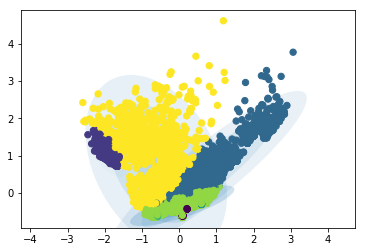

In [47]:
gaussian_mixture(tfidf_matrix, 7)

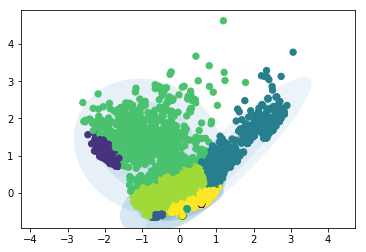

In [48]:
gaussian_mixture(tfidf_matrix, 8)

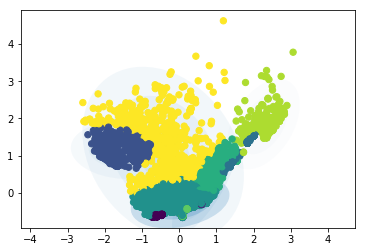

In [49]:
gaussian_mixture(tfidf_matrix, 9)

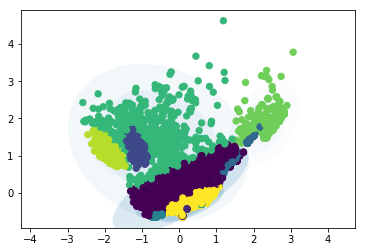

In [50]:
gaussian_mixture(tfidf_matrix, 10)

# Density Circles of Shootings in 10 KM areas

In [69]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def strRgb(mag, cmin, cmax):
    """ Return a hex string, as used in Tk plots. """
    return "#%02x%02x%02x" % rgb(mag, cmin, cmax)

def rgb(mag, cmin, cmax):
    """ Return a tuple of integers, as used in AWT/Java plots. """
    red, green, blue = floatRgb(mag, cmin, cmax)
    return int(red*255), int(green*255), int(blue*255)

def floatRgb(mag, cmin, cmax):
    """ Return a tuple of floats between 0 and 1 for R, G, and B. """
    # Normalize to 0-1
    try: x = float(mag-cmin)/(cmax-cmin)
    except ZeroDivisionError: x = 0.5 # cmax == cmin
    blue  = min((max((4*(0.75-x), 0.)), 1.))
    red   = min((max((4*(x-0.25), 0.)), 1.))
    green = min((max((4*math.fabs(x-0.5)-1., 0.)), 1.))
    return red, green, blue

def find_index(array, value):
    return

# Create a Map instance
map = folium.Map(location=[40,-79.5795],
    zoom_start=10, tiles = 'Stamen Terrain',control_scale=True)


def add_density_circles(map, shooting_data):
    #grabbing latitude and longitude data from .csv and passing it to create markers on the map
    #*****Eventually make this a function***********************
    latitudes = shooting_data['latitude']
    longitudes = shooting_data['longitude']

    #finding range because there is no way to graph every point in the file
    long_r = np.ptp(longitudes)
    lat_r = np.ptp(latitudes)

    long_min = np.min(longitudes)
    lat_min = np.min(latitudes)

    long_max = np.max(longitudes)
    lat_max = np.max(latitudes)
    print(long_r, long_min,long_max, lat_r, lat_min, lat_max)
    #creating the interval ranges of the longitude and latitudes to reduce the # of 
    lat_ints = np.zeros(1000)
    long_ints = np.zeros(1000)
    #creating interval values
    for j in range(1000):
        lat_ints[j] = lat_min+(j*lat_r/1000)
        long_ints[j] = long_min+(j*long_r/1000)


    #populating a longitude-latitude-count matrix

    lats = np.zeros(636)
    longs = np.zeros(636)
    counts = np.zeros(636)
    mat_it = 0
    index2 = 0
    index1 = 0
    total_count = 0
    lat_conflict_list = np.zeros(636)
    for i in range(len(longitudes)):
        lat_conflict = False
        long_conflict = False
        #finding the closest latitude value
        latitude = find_nearest(lat_ints,latitudes[i])
        #finding closest longitude value
        longitude = find_nearest(long_ints,longitudes[i])

        if i < 1:
            lats[mat_it] = latitude
            longs[mat_it] = longitude
            mat_it += 1
        
        longitude_range = math.radians(math.cos(latitude)) * 3.10686
        
        #creating arrays of indices where the latitude/longitude is repeated
        index1 = np.where(np.logical_and(lats>=latitude - .05, lats<=latitude + .05))
        index2 = np.where(np.logical_and(longs>=longitude - longitude_range, longs<=longitude + longitude_range))
        #parsing throught the index1/2 arrays to see if their is a unique pair that is being used
        #index is a tuple so 2 for loops are required
        for ind in index1:
            l = 0
            for inde in ind:
                if inde:
                    #stores the indices of the latitude conflict
                    lat_conflict_list[l] = inde
                    lat_conflict = True
                    l += 1            

        for ind1 in index2:
            for inde1 in ind1:
                #checking if the longitude conflict is the same index as any of those in the latitude conflicts
                if np.isin(inde1, lat_conflict_list) and lat_conflict == True:
                    long_conflict = True
                    #if both the longitude and latitude conflict add a shooting to that pair
                    counts[inde1] += 1
                    total_count += 1
        #only place the longitude latitude if the pair is unique
        if lat_conflict != True and long_conflict != True:           
            lats[mat_it] = latitude
            longs[mat_it] = longitude
            counts[mat_it] += 1
            total_count += 1
            mat_it += 1


    color = str

    for z in range(len(longs)):                           
        #accounts for potential NaNs
        if math.isnan(longs[z]) or math.isnan(lats[z]):
            continue
        else:
            color = strRgb(counts[z], counts.min(), counts.max()/3)
            
        #creating circluar marker that are color scaled with the number of shootings
            folium.Circle(
            location=[lats[z], longs[z]],
            radius = 10000,
            popup='# of shootings: '+ str(counts[z]),
            color = color,
            fill = True
            ).add_to(map)
            
    return 

add_density_circles(map, shooting_data)


98.3353 -166.097 -67.7617 51.867000000000004 19.4331 71.3001


In [70]:
map

In [53]:
map.save('Shooting_Density_Bubble_Color.html')

In [76]:
# Create a Map instance
scaled_map = folium.Map(location=[40,-79.5795],
    zoom_start=10, tiles = 'Stamen Terrain',control_scale=True)


def add_scaled_density_circles(map, shooting_data):
    #grabbing latitude and longitude data from .csv and passing it to create markers on the map
    #*****Eventually make this a function***********************
    latitudes = shooting_data['latitude']
    longitudes = shooting_data['longitude']

    #finding range because there is no way to graph every point in the file
    long_r = np.ptp(longitudes)
    lat_r = np.ptp(latitudes)

    long_min = np.min(longitudes)
    lat_min = np.min(latitudes)

    long_max = np.max(longitudes)
    lat_max = np.max(latitudes)
    print(long_r, long_min,long_max, lat_r, lat_min, lat_max)
    #creating the interval ranges of the longitude and latitudes to reduce the # of 
    lat_ints = np.zeros(1000)
    long_ints = np.zeros(1000)
    #creating interval values
    for j in range(1000):
        lat_ints[j] = lat_min+(j*lat_r/1000)
        long_ints[j] = long_min+(j*long_r/1000)


    #populating a longitude-latitude-count matrix

    lats = np.zeros(636)
    longs = np.zeros(636)
    counts = np.zeros(636)
    mat_it = 0
    index2 = 0
    index1 = 0
    total_count = 0
    lat_conflict_list = np.zeros(636)
    for i in range(len(longitudes)):
        lat_conflict = False
        long_conflict = False
        #finding the closest latitude value
        latitude = find_nearest(lat_ints,latitudes[i])
        #finding closest longitude value
        longitude = find_nearest(long_ints,longitudes[i])

        if i < 1:
            lats[mat_it] = latitude
            longs[mat_it] = longitude
            mat_it += 1
        
        longitude_range = math.radians(math.cos(latitude)) * 3.10686
        
        #creating arrays of indices where the latitude/longitude is repeated
        index1 = np.where(np.logical_and(lats>=latitude - .05, lats<=latitude + .05))
        index2 = np.where(np.logical_and(longs>=longitude - longitude_range, longs<=longitude + longitude_range))
        #parsing throught the index1/2 arrays to see if their is a unique pair that is being used
        #index is a tuple so 2 for loops are required
        for ind in index1:
            l = 0
            for inde in ind:
                if inde:
                    #stores the indices of the latitude conflict
                    lat_conflict_list[l] = inde
                    lat_conflict = True
                    l += 1            

        for ind1 in index2:
            for inde1 in ind1:
                #checking if the longitude conflict is the same index as any of those in the latitude conflicts
                if np.isin(inde1, lat_conflict_list) and lat_conflict == True:
                    long_conflict = True
                    #if both the longitude and latitude conflict add a shooting to that pair
                    counts[inde1] += 1
                    total_count += 1
        #only place the longitude latitude if the pair is unique
        if lat_conflict != True and long_conflict != True:           
            lats[mat_it] = latitude
            longs[mat_it] = longitude
            counts[mat_it] += 1
            total_count += 1
            mat_it += 1


    color = str

    for z in range(len(longs)):                           
        #accounts for potential NaNs
        if math.isnan(longs[z]) or math.isnan(lats[z]):
            continue
        else:
            color = strRgb(counts[z], counts.min(), counts.max()/3)
            
        #creating circluar marker that are color scaled with the number of shootings
            folium.Circle(
            location=[lats[z], longs[z]],
            radius = (100* counts[z]),
            popup='# of shootings: '+ str(counts[z]),
            color = color,
            fill = True
            ).add_to(scaled_map)
            
    return 

add_scaled_density_circles(scaled_map, shooting_data)

98.3353 -166.097 -67.7617 51.867000000000004 19.4331 71.3001


In [77]:
scaled_map

# Plotting shootings in user-defined city/county

In [54]:
#map shootings in specific county or city

def city_plot(city, shooting_data):
    
    city_data = shooting_data['city_or_county']
    latitudes_data = shooting_data['latitude']
    longitudes_data = shooting_data['longitude']
    
    count = 0
    
    latitudes = []
    
    longitudes =[]
    
    for i in range(len(city_data)):
        
        if city_data[i] == city:
            
            latitudes.append(latitudes_data[i])
            
            longitudes.append(longitudes_data[i])
            
            count += 1
            
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)
    print( np.nanmax(latitudes), np.nanmin(latitudes), np.nanmax(longitudes), np.nanmin(longitudes))
    print(latitudes, longitudes)
    #create map instance
    city_map = folium.Map(location=[latitudes[0], longitudes[0]],
    zoom_start=10, tiles = 'Stamen Terrain',control_scale=True)
    
    color = ['red', 'yellow', 'blue', 'green']
    
    
    if count > 1000:
        #finding range because there is no way to graph every point in the file
    
        long_min = np.nanmin(longitudes)
        lat_min = np.nanmin(latitudes)

        long_max = np.nanmax(longitudes)
        lat_max = np.nanmax(latitudes)
        
        long_r = long_max - long_min
        lat_r = lat_max - lat_min
        
        print(long_r, long_min,long_max, lat_r, lat_min, lat_max)
        #creating the interval ranges of the longitude and latitudes to reduce the # of 
        lat_ints = np.zeros(32)
        long_ints = np.zeros(32)
        #creating interval values
        for j in range(32):
            lat_ints[j] = lat_min+(j*lat_r/32)
            long_ints[j] = long_min+(j*long_r/32)

        #populating a longitude-latitude-count matrix

        lats = np.zeros(1000)
        longs = np.zeros(1000)
        counts = np.zeros(1000)
        mat_it = 0
        index2 = 0
        index1 = 0
        total_count = 0
        lat_conflict_list = np.zeros(636)
        for i in range(len(longitudes)):
            lat_conflict = False
            long_conflict = False
            #finding the closest latitude value
            latitude = find_nearest(lat_ints,latitudes[i])
            #finding closest longitude value
            longitude = find_nearest(long_ints,longitudes[i])

            if i < 1:
                lats[mat_it] = latitude
                longs[mat_it] = longitude
                mat_it += 1

            #creating arrays of indices where the latitude/longitude is repeated
            index1 = np.where(np.logical_and(lats>=latitude - .005, lats<=latitude + .005))
            index2 = np.where(np.logical_and(longs>=longitude - .00268, longs<=longitude + .00268))
            
            #parsing throught the index1/2 arrays to see if their is a unique pair that is being used
            #index is a tuple so 2 for loops are required
            for ind in index1:
                l = 0
                for inde in ind:
                    if inde:
                        #stores the indices of the latitude conflict
                        lat_conflict_list[l] = inde
                        lat_conflict = True
                        l += 1            

            for ind1 in index2:
                for inde1 in ind1:
                    #checking if the longitude conflict is the same index as any of those in the latitude conflicts
                    if np.isin(inde1, lat_conflict_list) and lat_conflict == True:
                        long_conflict = True
                        #if both the longitude and latitude conflict add a shooting to that pair
                        counts[inde1] += 1
                        total_count += 1
            #only place the longitude latitude if the pair is unique
            if lat_conflict != True and long_conflict != True:           
                lats[mat_it] = latitude
                longs[mat_it] = longitude
                counts[mat_it] += 1
                total_count += 1
                mat_it += 1
                
            colors = str
            print(total_count)
            for z in range(len(lats)):
                colors = strRgb(counts[z], counts.min(), counts.max()/3)

                if math.isnan(longs[z]) or math.isnan(lats[z]):
                    continue
                folium.Circle(
                    location=[lats[z], longs[z]],
                    radius = 5,
                    popup='# of shootings ' + str(counts[z]),
                    color = colors,
                    fill = True
                    ).add_to(city_map)
    else:
        for z in range(len(latitudes)):
            if math.isnan(longitudes[z]) or math.isnan(latitudes[z]):
                continue
            folium.Circle(
                location=[latitudes[z], longitudes[z]],
                radius = 5,
                popup='Shooting',
                color = color[z%4],
                fill = True
                ).add_to(city_map)

    
    return city_map


boston_map = city_plot('Boston', shooting_data)

boston_map

42.6061 37.7953 -71.0096 -85.6381
[37.7953 42.3622 42.3178 42.3606 42.2801 42.2483 42.3316 42.3407 42.2801
 42.3801 42.2867 42.267  42.3601 42.3132 42.2768 42.3226 42.2866 42.3134
 42.3409 42.3142 42.2738 42.325  42.3485 42.2869 42.3592 42.3042 42.3447
 42.325  42.3656 42.3012 42.3034 42.283  42.3006 42.267  42.2776 42.6061] [-85.6381 -71.0578 -71.0819 -71.1457 -71.1206 -71.1282 -71.0961 -71.0777
 -71.0927 -71.0226 -71.0639 -71.0989 -71.0589 -71.0869 -71.0864 -71.0801
 -71.0939 -71.058  -71.0773 -71.099  -71.102  -71.0593 -71.0832 -71.0652
 -71.0553 -71.0737 -71.072  -71.0593 -71.0096 -71.0679 -71.0685 -71.0773
 -71.0783 -71.0989 -71.0981 -78.7462]


In [55]:
boston_map.save('Shooting_Density_Bubble_Color.html')